In [1]:
%matplotlib inline


from __future__ import division

import numpy as np

import time, re, os, sys
import copy as cp

import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
import scipy.spatial.distance as dst
seaborn.set_context("paper",font_scale=2)
seaborn.set_style("whitegrid")


kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)


/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [31]:
n_samps = 60
x_samples = np.linspace(1,5,num=n_samps)

In [32]:
SIGMA = np.zeros([n_samps,n_samps])

In [33]:
#define parameters for the GP regression
k = 3
l = .5

In [34]:
distances = []
dist_MTX = np.zeros([n_samps,n_samps])
for idx1,samp1 in enumerate(x_samples):
    
    for idx2,samp2 in enumerate(x_samples):
        
        distances.append(samp1-samp2)
        dist_MTX[idx1,idx2] = np.abs(samp1-samp2)
        SIGMA[idx1,idx2] = kernel(samp1,samp2)  #+= 1e-6
        #if idx1==idx2:
        #    SIGMA[idx1,idx2]
            
SIGMA += np.eye(SIGMA.shape[0])*1e-6

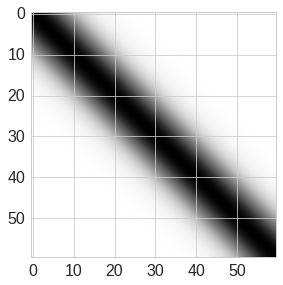

In [35]:
plt.imshow(SIGMA)

In [36]:
mu = np.zeros(n_samps)

In [37]:
mvn = multivariate_normal(mu,cov=SIGMA)

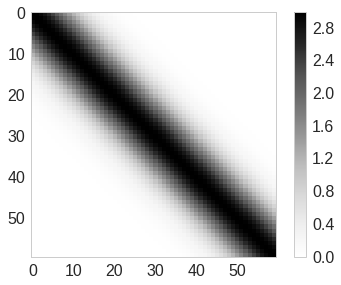

In [38]:
plt.imshow(SIGMA,interpolation='none')
plt.grid()
plt.colorbar()

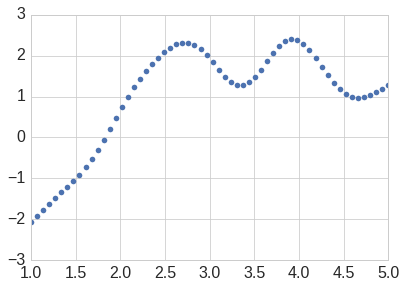

In [39]:
for i in range(1):
    plt.plot(x_samples,mvn.rvs(),'o')

## Plot  a Bunch of Samples from the prior distribution

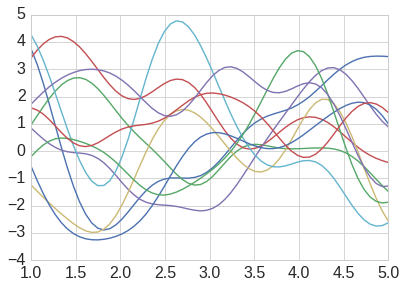

In [40]:
for i in range(10):
    plt.plot(x_samples,mvn.rvs())

#

$f∗|X∗, X,f ∼ \mathcal{N}(
K(X∗, X)K(X, X)^{−1}f,
K(X∗, X∗) − K(X∗, X)K(X, X)^{−1}K(X, X∗))

.$

$p(x|m, Σ) = (2π)
−D/2
|Σ|
−1/2
exp^{−\frac{1}{2}(x − m)'Σ^{−1}(x − m)}$

In [163]:
type(x_samples)==np.ndarray

True

In [164]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
    return dists

In [217]:
def get_covariance_matrix(x,y=None,k=3,l=.5,add_offset=1e-6,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = k*np.exp(-.5*distsSq/(l**2)) 
    
    cov += add_offset
    return cov

# Generate Data

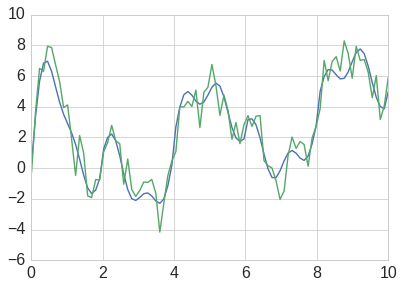

In [220]:
#D = np.array([[3,.1],[4,.1],[5,.1],[40,2],[80,-4]])
xs = np.linspace(0.01,10,num=90)
ys = np.sin(.5*np.pi*xs)*3 + np.sin(2*np.pi*xs) + (1/np.exp(xs/2))*6*np.sin(1*np.pi*xs) + xs//2
#ys = (1/np.exp(xs/2))*4*np.sin(2*np.pi*xs) + xs/2
#ys = np.hstack([np.zeros(50),np.ones(50)*2]) - 1
plt.plot(xs,ys)

D = np.vstack([xs,ys+np.random.normal(scale=1,size=xs.shape)]).T

plt.plot(xs,D[:,1])

n_samps = 220
x_samples = np.linspace(0,10,num=n_samps)

In [221]:
#define parameters for the GP regression
k = 1e1
l = 7e-2

In [222]:
dst.cdist(np.vstack([x_samples,np.zeros(x_samples.shape)]).T,np.vstack([D[:,0],np.zeros(D.shape[0])]).T).shape

(220, 90)

In [224]:
K = get_covariance_matrix(D[:,0],k=k,l=l,add_offset=0)#np.zeros([D.shape[0],D.shape[0]])
K += 2*np.eye(D.shape[0])

Kst = get_covariance_matrix(x=x_samples,y=D[:,0],k=k,l=l,add_offset=0)
Kstst = get_covariance_matrix(x=x_samples,k=k,l=l,add_offset=0)


In [225]:
GP_mean = Kst.dot(np.linalg.inv(K)).dot(D[:,1])

In [226]:
GP_cov = (Kstst - Kst.dot(np.linalg.inv(K)).dot(Kst.T)) + np.eye(GP_mean.shape[0])*1e-6

In [227]:
GP_posterior = multivariate_normal(GP_mean,GP_cov)

#  This is success enjoy the beautiful plot of samples from the posterior

(0, 6.3)

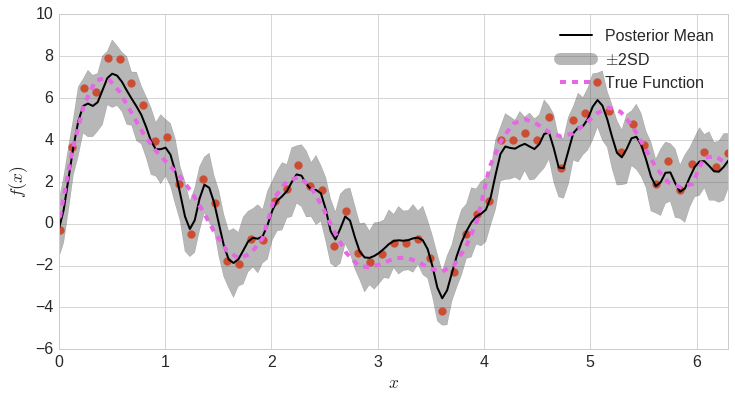

In [228]:
plt.figure(figsize=(12,6))

ax = plt.gca()

#for i in range(4):
#    ax.plot(x_samples,GP_posterior.rvs())
    
#ax.plot(x_samples,GP_posterior.rvs(),label='Posterior Samples')


ax.plot(x_samples,GP_mean,linewidth=2,color='k',label='Posterior Mean')



ax.fill_between(x_samples, GP_mean-np.sqrt(np.diag(GP_cov)), GP_mean+np.sqrt(np.diag(GP_cov)), facecolor=[.3]*3,alpha=.4, interpolate=True)
ax.plot([0], [0], color=[.3]*3,alpha=.4,linewidth=12, label='$\pm$2SD')


ax.plot(D[:,0],ys,color=[.9,.4,.9],linestyle='--',linewidth=4,label='True Function')
ax.scatter(D[:,0],D[:,1],s=64,color=[.8,.3,.2])

ax.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.xlim(xmin=0,xmax=6.3)

## Samples From Posterior Distribution of Functions

In [152]:
for idx1,samp1 in enumerate(x_samples):
    
    for idx2,samp2 in enumerate(x_samples):
        
        
        SIGMA[idx1,idx2] = kernel(samp1,samp2)  #+= 1e-6
        #if idx1==idx2:
        #    SIGMA[idx1,idx2]
            
SIGMA += np.eye(SIGMA.shape[0])*1e-6

mu = np.zeros(x_samples.shape)
GP_prior = multivariate_normal(mu,cov=SIGMA)

IndexError: index 60 is out of bounds for axis 1 with size 60

ValueError: x and y must have same first dimension

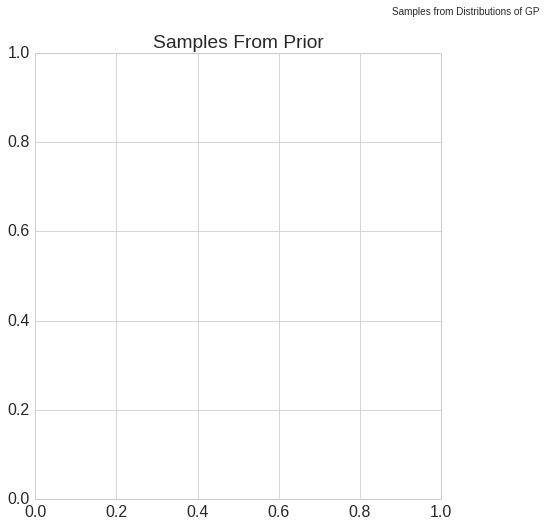

In [153]:
plt.figure(figsize=(16,8))
plt.suptitle('Samples from Distributions of GP \n\n')

plt.subplot(1,2,1)
plt.title('Samples From Prior')
ax = plt.gca()
for i in range(3):
    ax.plot(x_samples,mvn.rvs())
    
ax.plot(x_samples,mvn.rvs(),label='Samples')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')


plt.subplot(1,2,2)
ax = plt.gca()
plt.title('\nSamples From Posterior')
for i in range(3):
    ax.plot(x_samples,GP_posterior.rvs())
    
ax.plot(x_samples,GP_posterior.rvs(),label='Samples')
plt.xlabel(r'$x$')




# Repeat Procedure in 2D

In [1542]:
n_samps = 100
x_pos = np.linspace(1,5,num=n_samps)
y_pos = np.linspace(3,5,num=n_samps)


In [ ]:
kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

In [ ]:
SIGMA = np.zeros([n_samps,n_samps])

In [ ]:
#define parameters for the GP regression
k = 3
l = .5

In [ ]:
for idx1,samp1 in enumerate(x_samples):
    
    for idx2,samp2 in enumerate(x_samples):
        
        
        SIGMA[idx1,idx2] = kernel(samp1,samp2)  #+= 1e-6
        #if idx1==idx2:
        #    SIGMA[idx1,idx2]
            
SIGMA += np.eye(SIGMA.shape[0])*1e-6